# imports

In [606]:
import datetime
import importlib
import pandas as pd, numpy as np
import scipy
import matplotlib.pyplot as plt
from numpy_ext import rolling_apply as rolling_apply_ext
import talib
from talib import MA_Type
import numpy.linalg

In [697]:
date_str_20220901 = "2022-09-01"
date_str_20220919 = "2022-09-19"
date_str_20220920 = "2022-09-20"
date_str_20220921 = "2022-09-21"
date_str_20220922 = "2022-09-22"
date_str_20220923 = "2022-09-23"
date_str_20220924 = "2022-09-24"
date_str_20220925 = "2022-09-25"
date_str_20220930 = "2022-09-30"

date_str_20230801 = "2023-08-01"
date_str_20230803 = "2023-08-03"
date_str_20230806 = "2023-08-06"
date_str_20230809 = "2023-08-09"
date_str_20230810 = "2023-08-10"
date_str_20230811 = "2023-08-11"
date_str_20230812 = "2023-08-12"
date_str_20230813 = "2023-08-13"
date_str_20230814 = "2023-08-14"
date_str_20230815 = "2023-08-15"
date_str_20230816 = "2023-08-16"
date_str_20230831 = "2023-08-31"

date_str_20230901 = "2023-09-01"
date_str_20230930 = "2023-09-30"

In [9]:
df = pd.read_csv('algo/data/market_data_binance.by_minute_ALL_2022-09-19T04:00:00Z_2022-09-26T03:59:00Z.csv')
df['time'] = pd.to_datetime(df['timestamp'], unit='s')
df_close = df.pivot(index='time', columns='symbol', values='close')

In [157]:
df_202209 = pd.read_csv('algo/data/market_data_binance.by_minute_ALL_2022-09-01T04:00:00Z_2022-09-30T03:59:00Z.csv')
df_202209['time'] = pd.to_datetime(df_202209['timestamp'], unit='s')
df_close_202209 = df_202209.pivot(index='time', columns='symbol', values='close')
df_close_20220919_20220922 = df_close_202209[(df_close_202209.index >= date_str_20220919) & (df_close_202209.index < date_str_20220922)]

In [698]:
df_202308 = pd.read_csv('algo/data/market_data_binance.by_minute_ALL_2023-08-01T04:00:00Z_2023-08-31T03:59:00Z.csv')
df_202308['time'] = pd.to_datetime(df_202308['timestamp'], unit='s')
df_close_202308 = df_202308.pivot(index='time', columns='symbol', values='close')
df_close_20230806_20230809 = df_close_202308[(df_close_202308.index >= date_str_20230806) & (df_close_202308.index < date_str_20230809)]
df_close_20230816_20230831 = df_close_202308[(df_close_202308.index >= date_str_20230816) & (df_close_202308.index < date_str_20230831)]

In [696]:
df_202309 = pd.read_csv('algo/data/market_data_binance.by_minute_ALL_2023-09-01T04:00:00Z_2023-09-30T03:59:00Z.csv')
df_202309['time'] = pd.to_datetime(df_202309['timestamp'], unit='s')
df_close_202309 = df_202309.pivot(index='time', columns='symbol', values='close')

In [699]:
def get_close_between_datetime(sample_period_minutes, symbols, start_datetime_str, end_datetime_str, if_2023=True):
    df = pd.concat([df_close_202308, df_close_202309]) if if_2023 else df_close_202209
    df1 = df[(df.index >= start_datetime_str) & (df.index < end_datetime_str)][symbols].resample(f'{sample_period_minutes}min').last().dropna()
    #return pd.concat([df1, df2])
    return df1

def get_close_between_date(sample_period_minutes, symbols, start_date_str, end_date_str, if_2023=True):   
    return get_close_between_datetime(sample_period_minutes, symbols, start_date_str + " 00:00:000", end_date_str + " 00:00:000", if_2023=if_2023)

In [700]:
def get_high_corr_symbols(start_symbol, num, candidate_symbols, high_corr=True):
    df_corr = df_close_202308[(df_close_202308.index >= date_str_20230816) & (df_close_202308.index < date_str_20230831)].resample(f'10min').last().corr()

    def best_corr(sym, symbols):
        corrs = []
        for symbol_col in symbols:
            if sym == symbol_col: break
            corrs.append((df_corr.loc[sym][symbol_col], sym, symbol_col,))

        abs_corrs = [(abs(c[0]), c[1], c[2],) for c in corrs]
        pick = sorted(abs_corrs, reverse=high_corr)[0]
        print(f'{pick}')
        return pick[2]

    ret = [start_symbol]
    symbols = [s for s in candidate_symbols if s != start_symbol]
    symbol_base = start_symbol
    for _ in range(num-1):
        symbols = [s for s in symbols if s != symbol_base]
        symbol = best_corr(symbol_base, symbols)
        ret.append(symbol)
        symbol_base = symbol

    return ret

In [730]:
def get_high_corr_symbols_set_of(set_size, set_num, candidate_symbols, high_corr=True):
    '''
    high_corr: True if getting highest, False if getting lowest.
    '''
    df_corr = df_close_202308[(df_close_202308.index >= date_str_20230816) & (df_close_202308.index < date_str_20230831)].resample(f'10min').last().corr()

    def find_start_symbol(symbols_pool):
        corrs = []
        for symbol_row in symbols_pool:
            for symbol_col in symbols_pool:
                if symbol_row == symbol_col: break
                corrs.append((df_corr.loc[symbol_row][symbol_col], symbol_row, symbol_col,))

        abs_corrs = [(abs(c[0]), c[1], c[2],) for c in corrs]
        pick = sorted(abs_corrs, reverse=high_corr)[0]
        start_symbol = pick[1]
        return start_symbol

    start_symbol = find_start_symbol(candidate_symbols)
    ret = []
    symbols_pool = [s for s in candidate_symbols if s != start_symbol]
    for _ in range(set_num):
        print(f'start_symbol: {start_symbol}')
        symbols = get_high_corr_symbols(start_symbol, set_size, symbols_pool, high_corr=high_corr)
        ret.append(symbols)

        symbols_pool = [s for s in symbols_pool if s not in symbols]
        start_symbol = find_start_symbol(symbols_pool)
        symbols_pool = [s for s in symbols_pool if s != start_symbol]
    return ret

In [731]:
symbols_pool = [s for _, s in sorted([(m, s) for s, m in df_close_202309.mean().items() if m > 10 and m < 500], reverse=True)]
# remove duplicates within USDT / BUSD swap
symbols_pool = [s for s in symbols_pool if s not in [s.replace('USDT', 'BUSD') for s in symbols_pool if 'USDT' in s]]
symbols_pool

['BIFIUSDT',
 'BNBUSDT',
 'BCHUSDT',
 'XMRUSDT',
 'GNOUSDT',
 'QNTUSDT',
 'LTCUSDT',
 'AAVEUSDT',
 'KP3RUSDT',
 'ILVUSDT',
 'COMPUSDT',
 'GMXUSDT',
 'TRBUSDT',
 'WNXMUSDT',
 'DASHUSDT',
 'ZECUSDT',
 'EGLDUSDT',
 'RPLUSDT',
 'FARMUSDT',
 'BNBUPUSDT',
 'SOLUSDT',
 'KSMUSDT',
 'SSVUSDT',
 'ETCUSDT',
 'MLNUSDT',
 'NMRUSDT',
 'DCRUSDT',
 'CREAMBUSD',
 'ALCXUSDT']

In [739]:
set_size, set_num = 2, 6
symbols_sets = get_high_corr_symbols_set_of(set_size, set_num, symbols_pool, high_corr=True)
symbols_sets

start_symbol: SOLUSDT
(0.9628572347045794, 'SOLUSDT', 'ILVUSDT')
start_symbol: KSMUSDT
(0.9571854163567327, 'KSMUSDT', 'KP3RUSDT')
start_symbol: COMPUSDT
(0.9374257507980596, 'COMPUSDT', 'LTCUSDT')
start_symbol: ALCXUSDT
(0.9353552778834163, 'ALCXUSDT', 'BIFIUSDT')
start_symbol: AAVEUSDT
(0.9341762994839783, 'AAVEUSDT', 'BNBUSDT')
start_symbol: FARMUSDT
(0.9301003530218976, 'FARMUSDT', 'GMXUSDT')


[['SOLUSDT', 'ILVUSDT'],
 ['KSMUSDT', 'KP3RUSDT'],
 ['COMPUSDT', 'LTCUSDT'],
 ['ALCXUSDT', 'BIFIUSDT'],
 ['AAVEUSDT', 'BNBUSDT'],
 ['FARMUSDT', 'GMXUSDT']]

In [733]:
symbols_sets_low_corr = get_high_corr_symbols_set_of(set_size, set_num, symbols_pool, high_corr=False)
symbols_sets_low_corr

start_symbol: CREAMBUSD
(0.00421959376963278, 'CREAMBUSD', 'QNTUSDT')
start_symbol: DCRUSDT
(0.021016413392087426, 'DCRUSDT', 'RPLUSDT')
start_symbol: TRBUSDT
(0.039547777764650176, 'TRBUSDT', 'ILVUSDT')
start_symbol: ETCUSDT
(0.12663027493682738, 'ETCUSDT', 'EGLDUSDT')


[['CREAMBUSD', 'QNTUSDT'],
 ['DCRUSDT', 'RPLUSDT'],
 ['TRBUSDT', 'ILVUSDT'],
 ['ETCUSDT', 'EGLDUSDT']]

In [528]:
#symbols = ['YFIIUSDT', 'ETHUSDT', 'PAXGUSDT', 'BIFIUSDT', 'BNBUSDT']
#symbols = ['YFIIUSDT', 'ETHUSDT', 'BIFIUSDT']
symbols = ['BNBUPUSDT', 'BNBUSDT', 'SOLUSDT']

In [529]:
get_close_between_date(10, symbols, date_str_20230806, date_str_20230809).dropna().head()

symbol,BNBUPUSDT,BNBUSDT,SOLUSDT
time,,,
2023-08-06 02:50:00,28.47,244.0,22.83
2023-08-06 03:10:00,28.49,244.2,22.81
2023-08-06 03:20:00,28.73,244.8,22.83
2023-08-06 03:30:00,28.65,244.6,22.86
2023-08-06 03:40:00,28.65,244.5,22.82


<Axes: xlabel='time'>

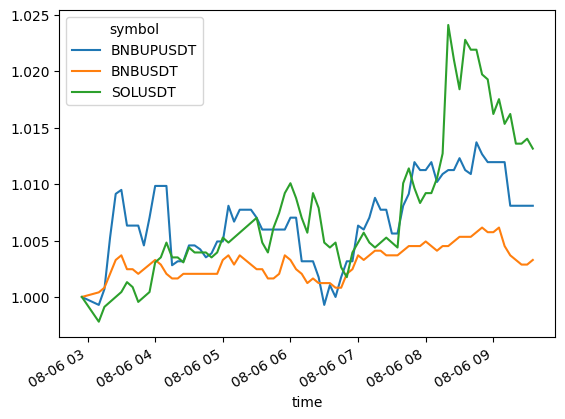

In [530]:
df = get_close_between_date(5, symbols, date_str_20230806, date_str_20230809).dropna()
(df / df.iloc[0]).plot()

In [531]:
df = get_close_between_date(5, symbols, date_str_20230806, date_str_20230809).dropna()
(df / df.iloc[0])

symbol,BNBUPUSDT,BNBUSDT,SOLUSDT
time,,,
2023-08-06 02:55:00,1.000000,1.000000,1.000000
2023-08-06 03:10:00,0.999298,1.000410,0.997810
2023-08-06 03:15:00,1.000702,1.000820,0.999124
2023-08-06 03:20:00,1.005269,1.002049,0.999562
2023-08-06 03:25:00,1.009132,1.003279,1.000000
...,...,...,...
2023-08-06 09:15:00,1.008079,1.003689,1.016207
2023-08-06 09:20:00,1.008079,1.003279,1.013579
2023-08-06 09:25:00,1.008079,1.002869,1.013579


In [682]:
get_close_between_date(1, symbols, date_str_20230806, date_str_20230809).corr().style.background_gradient(cmap='coolwarm')

symbol,AAVEUSDT,BCHUSDT,GMXUSDT,AVAXUSDT
symbol,,,,
AAVEUSDT,1.000000,0.798047,0.628399,0.780592
BCHUSDT,0.798047,1.000000,0.671571,0.637695
GMXUSDT,0.628399,0.671571,1.000000,0.661198
AVAXUSDT,0.780592,0.637695,0.661198,1.000000


In [684]:
get_close_between_date(1, symbols, date_str_20230806, date_str_20230831).corr().style.background_gradient(cmap='coolwarm')

symbol,AAVEUSDT,BCHUSDT,GMXUSDT,AVAXUSDT
symbol,,,,
AAVEUSDT,1.000000,0.944787,0.949018,0.941293
BCHUSDT,0.944787,1.000000,0.892530,0.878842
GMXUSDT,0.949018,0.892530,1.000000,0.949192
AVAXUSDT,0.941293,0.878842,0.949192,1.000000


In [689]:
get_close_between_date(1, symbols_sets[3], date_str_20230806, date_str_20230831).corr().style.background_gradient(cmap='coolwarm')

symbol,AAVEUSDT,BCHUSDT,GMXUSDT,AVAXUSDT
symbol,,,,
AAVEUSDT,1.000000,0.944787,0.949018,0.941293
BCHUSDT,0.944787,1.000000,0.892530,0.878842
GMXUSDT,0.949018,0.892530,1.000000,0.949192
AVAXUSDT,0.941293,0.878842,0.949192,1.000000


In [692]:
get_close_between_date(1, symbols_sets_low_corr[0], date_str_20230806, date_str_20230831).corr().style.background_gradient(cmap='coolwarm')

symbol,BNBUPUSDT,ALCXUSDT
symbol,,
BNBUPUSDT,1.000000,0.927344
ALCXUSDT,0.927344,1.000000


In [693]:
get_close_between_date(1, symbols_sets_low_corr[1], date_str_20230806, date_str_20230831).corr().style.background_gradient(cmap='coolwarm')

symbol,TRBUSDT,KSMUSDT
symbol,,
TRBUSDT,1.000000,0.173718
KSMUSDT,0.173718,1.000000


# Solve the minimal predictability condition

In [781]:
import algo.minimal_predictability.calculate
importlib.reload(algo.minimal_predictability.calculate)

<module 'algo.minimal_predictability.calculate' from '/home/junlim/projects/mean_reversal/algo/minimal_predictability/calculate.py'>

# Trading calculations

In [780]:
import algo.statarbitrage.bband
importlib.reload(algo.statarbitrage.bband)

<module 'algo.statarbitrage.bband' from '/home/junlim/projects/mean_reversal/algo/statarbitrage/bband.py'>

# Static Portfolio construction

In [784]:
#df_prices = get_close_between_date(10, symbols, date_str_20220919, date_str_20220922)
#df_prices = get_close_between_date(1, symbols_2022, date_str_20220919, date_str_20220922, if_2023=False)
#symbols = ['YFIIUSDT', 'ETHUSDT', 'BIFIUSDT']
df_prices = get_close_between_date(4, symbols, date_str_20230811, date_str_20230814).dropna()
#df_prices = df_close_20230806_20230809[symbols].dropna()
var_eigen_vals, var_eigen_vecs, wgts = algo.minimal_predictability.calculate.get_var1_wgts_values_transpose(*df_prices.values.T)

In [785]:
df_prices.tail()

symbol,FARMUSDT,GMXUSDT
time,,
2023-08-13 23:40:00,24.75,46.32
2023-08-13 23:44:00,24.75,46.32
2023-08-13 23:48:00,24.70,46.34
2023-08-13 23:52:00,24.70,46.32
2023-08-13 23:56:00,24.70,46.24


In [786]:
var_eigen_vals

array([0.88433704, 0.99161675])

In [787]:
print(var_eigen_vecs[:,0])
print(wgts[:,0])

[ 0.99899139 -0.0449021 ]
[14.86924423 -0.40193596]


In [788]:
df_prices.iloc[-1] * var_eigen_vecs[:,0]

symbol
FARMUSDT    24.675087
GMXUSDT     -2.076273
Name: 2023-08-13 23:56:00, dtype: float64

In [789]:
df_prices.iloc[-1] * wgts[:,0]

symbol
FARMUSDT    367.270333
GMXUSDT     -18.585519
Name: 2023-08-13 23:56:00, dtype: float64

In [790]:
print(var_eigen_vecs[:,-1])
print(wgts[:,-1])

[0.0449021  0.99899139]
[0.33010059 1.41726096]


<Axes: xlabel='time'>

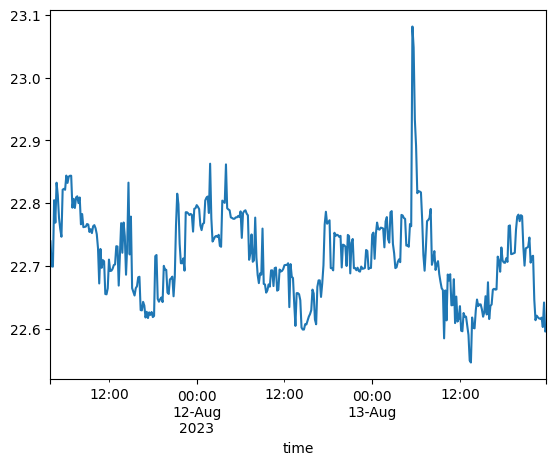

In [791]:
(get_close_between_date(10, symbols, date_str_20230811, date_str_20230814) * var_eigen_vecs[:,0]).sum(axis=1).plot()

<Axes: xlabel='time'>

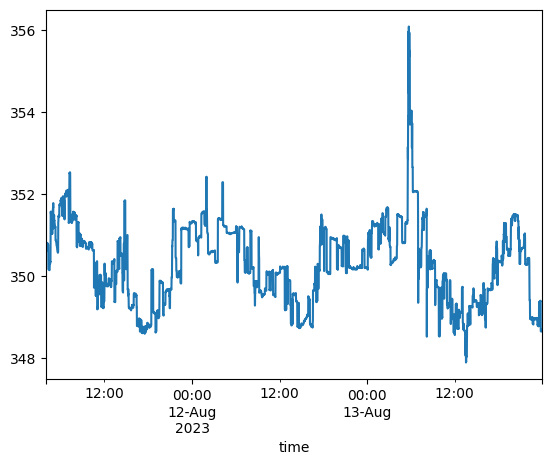

In [792]:
(get_close_between_date(1, symbols, date_str_20230811, date_str_20230814) * wgts[:,0]).sum(axis=1).plot()

## Bollinger bands trading

In [793]:
trading_param = algo.statarbitrage.bband.TradingParam(60, 2.0)
values = algo.statarbitrage.bband.add_features(df_prices, var_eigen_vecs[:,0], trading_param)

<Axes: xlabel='time'>

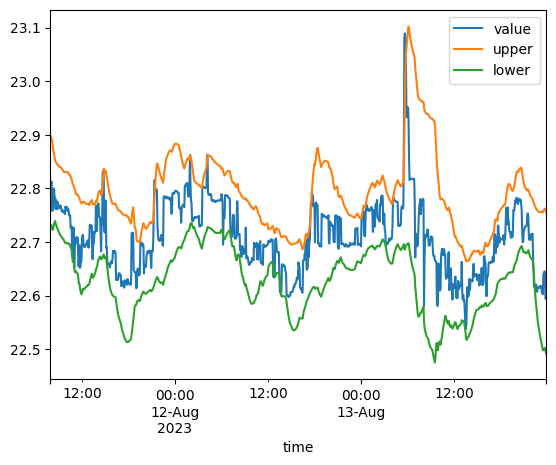

In [794]:
values[['value', 'upper', 'lower']].plot()

<Axes: xlabel='time'>

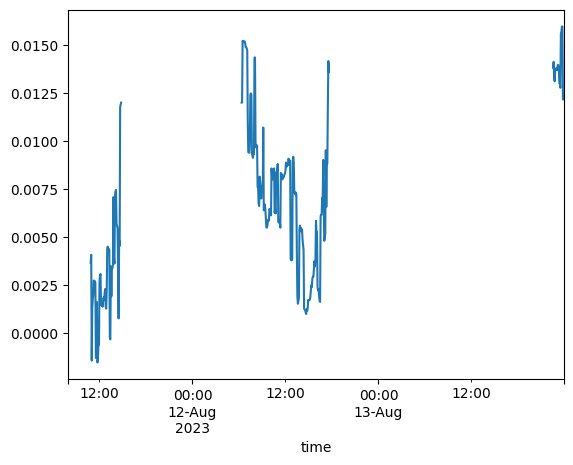

In [795]:
(values.profit_raw / values.position_size).cumsum().plot()

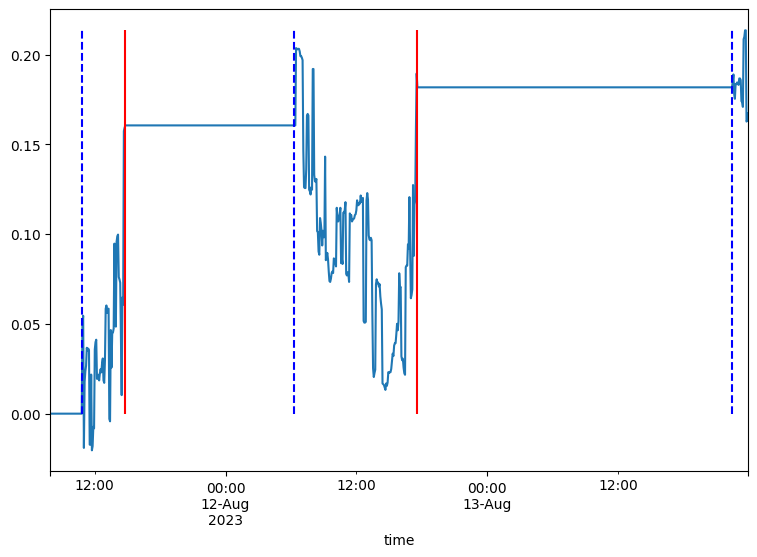

In [796]:
ax = values.profit_raw.cumsum().iloc[:,].plot(figsize=(9, 6))
ymin, ymax = 0, values.profit_raw.cumsum().max()

# add vertical lines
ax.vlines(x=list(values[values.position_changed == +1].index), ymin=ymin, ymax=ymax, color='b', linestyles='dashed', label='enter')
ax.vlines(x=list(values[values.position_changed == -1].index), ymin=ymin, ymax=ymax, color='r', linestyles='solid', label='leave')

plt.show()

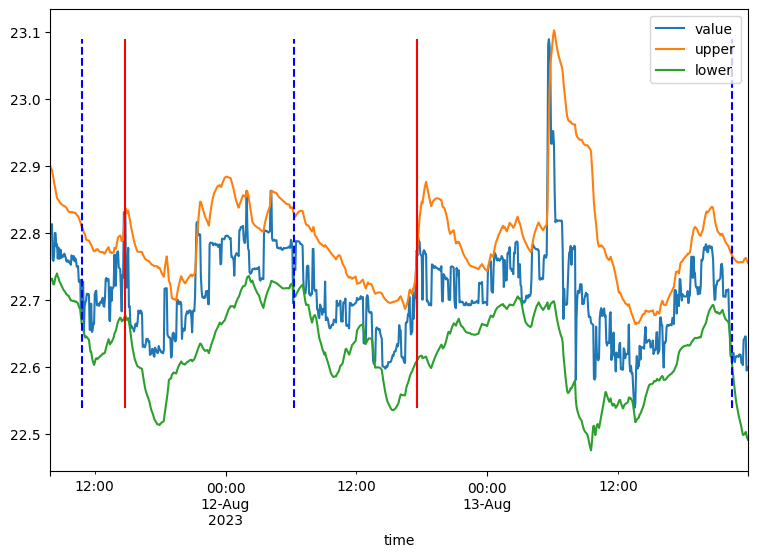

In [797]:
ax = values[['value', 'upper', 'lower']].dropna().plot(figsize=(9, 6))
ymin, ymax = values.value.min(), values.value.max()

# add vertical lines
ax.vlines(x=list(values[values.position_changed == +1].index), ymin=ymin, ymax=ymax, color='b', linestyles='dashed', label='enter')
ax.vlines(x=list(values[values.position_changed == -1].index), ymin=ymin, ymax=ymax, color='r', linestyles='solid', label='leave')

plt.show()

# Rolling-based Portfolio Construction

In [782]:
def get_var1_wgts_values_transpose_rolling(df_prices, window, rebalance_period_minutes, order, if_evecs):
    '''
    order: 0 for the smallest eigen value, -1 for the largest.
    if_evecs: True for eigen vectors, False for weights (e-vecs / sqrt(cov))
    '''
    i = 1 if if_evecs else 2
    rolling_wgt = rolling_apply_ext(lambda *vsT: algo.minimal_predictability.calculate.get_var1_wgts_values_transpose(*vsT)[i][:,order], window, *df_prices.values.T)
    df_rolling_wgt = pd.DataFrame(rolling_wgt, index=df_prices.index, columns=df_prices.columns)
    # shift by one time unit as the weight up to now will practically be applied in the next step. (?)
    df_rolling_wgt = df_rolling_wgt.shift()
    #df_rolling_wgt_resampled = df_rolling_wgt.resample(f'{rebalance_period_minutes}min').first().resample(f'{sample_unit_minutes}min').first().ffill()
    df_rolling_wgt_resampled = df_rolling_wgt.resample(f'{rebalance_period_minutes}min').first()
    return df_rolling_wgt, df_rolling_wgt_resampled

In [783]:
def get_trading_result(symbols, trading_param, if_evecs):
    #fitting_window, rebalance_period = 180, 180
    train_data_sample_period_minutes = 10
    fitting_window = 180
    rebalance_period_minutes = 120
    df_prices_train_sampled = get_close_between_date(train_data_sample_period_minutes, symbols, date_str_20230901, date_str_20230930).dropna()
    df_rolling_wgt, df_rolling_wgt_resampled = algo.minimal_predictability.calculate.get_var1_wgts_values_transpose_rolling(
        df_prices_train_sampled, window=fitting_window, 
        rebalance_period_minutes=rebalance_period_minutes, 
        order=0, if_evecs=if_evecs)

    df_prices = get_close_between_date(1, symbols, date_str_20230901, date_str_20230930).dropna()
    df_prices_list = []
    head_buffer_length = trading_param.bb_windows
    wgt_resammpled = df_rolling_wgt_resampled
    for i, index_head in enumerate(wgt_resammpled.index):
        if i == len(wgt_resammpled.index)-1: continue

        index_head_buffered = index_head - pd.Timedelta(minutes=head_buffer_length)
        index_tail = wgt_resammpled.index[i+1]
        df_prices_i = df_prices[(df_prices.index < index_tail) & (df_prices.index >= index_head_buffered)]
        df_prices_list.append((index_head_buffered, index_head, index_tail, df_prices_i, wgt_resammpled.loc[index_head]))

    values_list = []
    for index_head_buffered, index_head, index_tail, df_prices_i, wgt in df_prices_list:
        values_i = algo.statarbitrage.bband.add_features(df_prices_i, wgt, trading_param)
        values_i['value_0'] = values_i.value - values_i.value.iloc[0]
        values_list.append(values_i)

    return values_list

symbols: ['SOLUSDT', 'ILVUSDT']


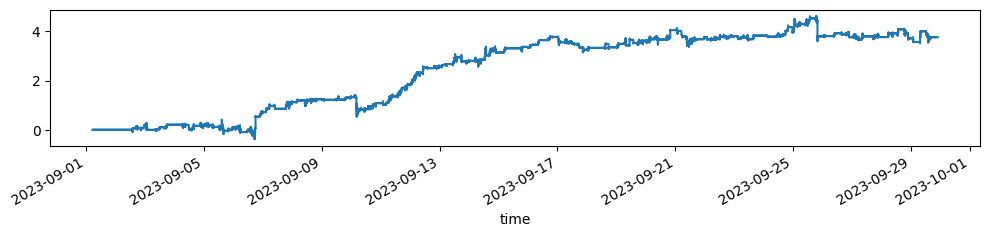

symbols: ['KSMUSDT', 'KP3RUSDT']


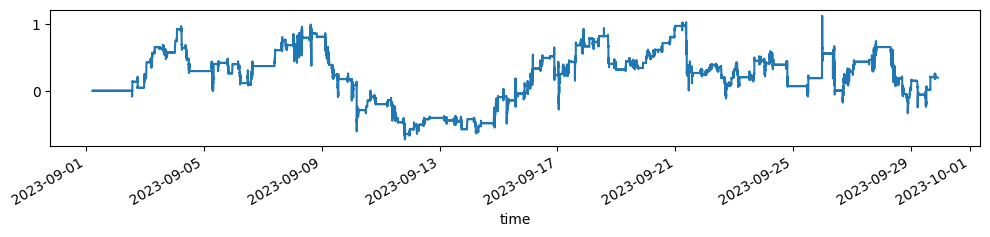

symbols: ['COMPUSDT', 'LTCUSDT']


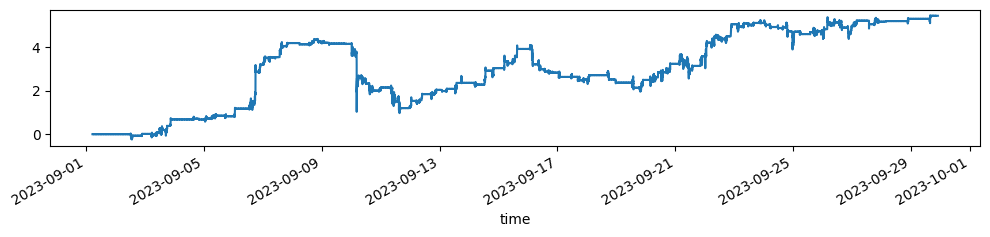

symbols: ['ALCXUSDT', 'BIFIUSDT']


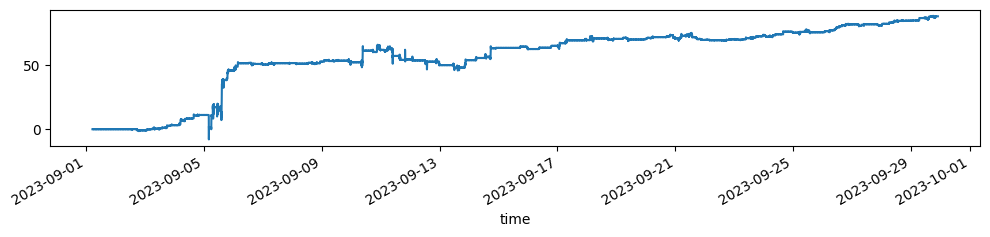

symbols: ['AAVEUSDT', 'BNBUSDT']


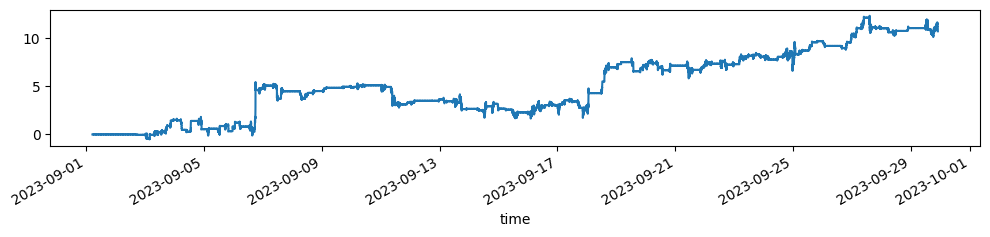

symbols: ['FARMUSDT', 'GMXUSDT']


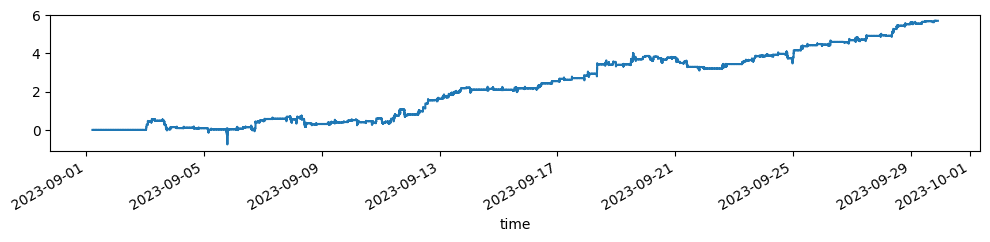

In [771]:
trading_param = algo.statarbitrage.bband.TradingParam(60, 2.0)
for symbols in symbols_sets:
    print(f'symbols: {symbols}')
    values_list = get_trading_result(symbols, trading_param, if_evecs=True)
    values_concat = pd.concat(values_list)
    ax = values_concat.profit_raw.cumsum().plot(figsize=(12, 2))
    ymin, ymax = 0, values_concat.profit_raw.cumsum().max()
    
    #ax.vlines(x=list(df_rolling_wgt_resampled.index), ymin=ymin, ymax=ymax, color='g', linestyles='dashed', label='rebalance')
    #ax.vlines(x=list(values_concat[values_concat.position_changed == +1].index), ymin=ymin, ymax=ymax, color='b', linestyles='dashed', label='enter')
    #ax.vlines(x=list(values_concat[values_concat.position_changed == -1].index), ymin=ymin, ymax=ymax, color='r', linestyles='solid', label='leave')
    
    plt.show()

symbols: ['SOLUSDT', 'ILVUSDT']


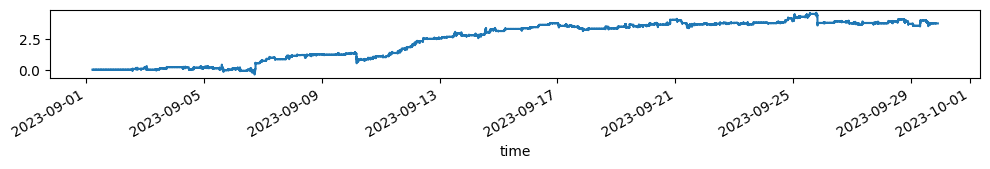

symbols: ['KSMUSDT', 'KP3RUSDT']


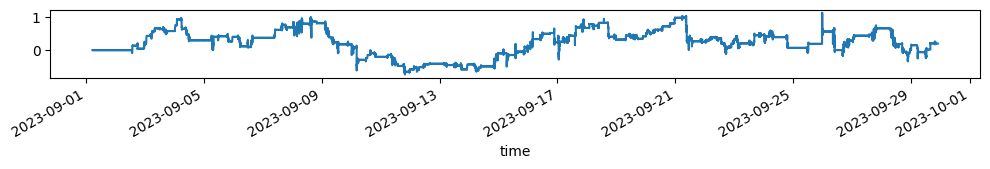

symbols: ['COMPUSDT', 'LTCUSDT']


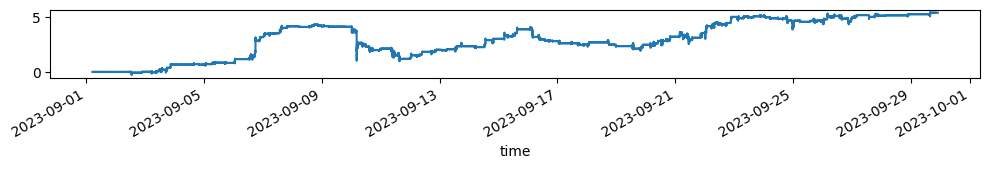

symbols: ['ALCXUSDT', 'BIFIUSDT']


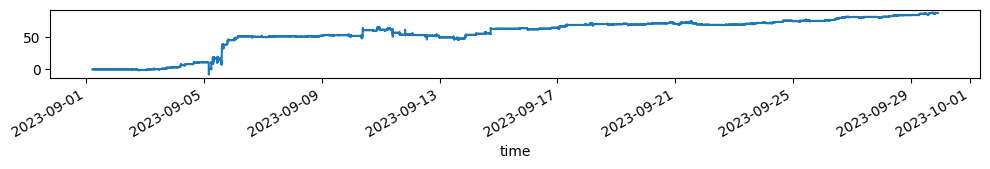

symbols: ['AAVEUSDT', 'BNBUSDT']


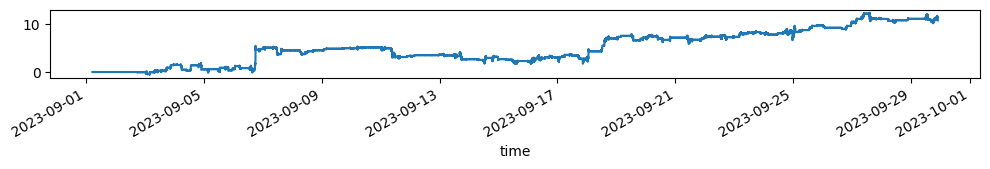

symbols: ['FARMUSDT', 'GMXUSDT']


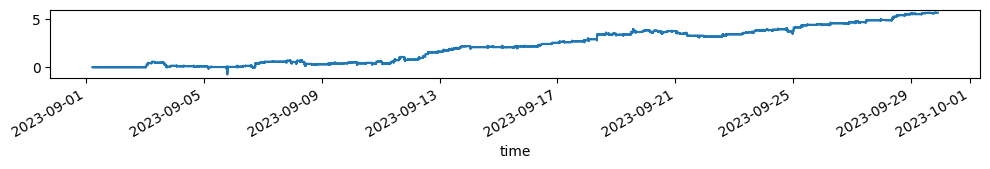

In [773]:
trading_param = algo.statarbitrage.bband.TradingParam(60, 2.0)
for symbols in symbols_sets:
    print(f'symbols: {symbols}')
    values_list = get_trading_result(symbols, trading_param, if_evecs=True)
    values_concat = pd.concat(values_list)
    ax = values_concat.profit_raw.cumsum().plot(figsize=(12, 1))
    ymin, ymax = 0, values_concat.profit_raw.cumsum().max()
    
    #ax.vlines(x=list(df_rolling_wgt_resampled.index), ymin=ymin, ymax=ymax, color='g', linestyles='dashed', label='rebalance')
    #ax.vlines(x=list(values_concat[values_concat.position_changed == +1].index), ymin=ymin, ymax=ymax, color='b', linestyles='dashed', label='enter')
    #ax.vlines(x=list(values_concat[values_concat.position_changed == -1].index), ymin=ymin, ymax=ymax, color='r', linestyles='solid', label='leave')
    
    plt.show()

symbols: ['SOLUSDT', 'ILVUSDT']


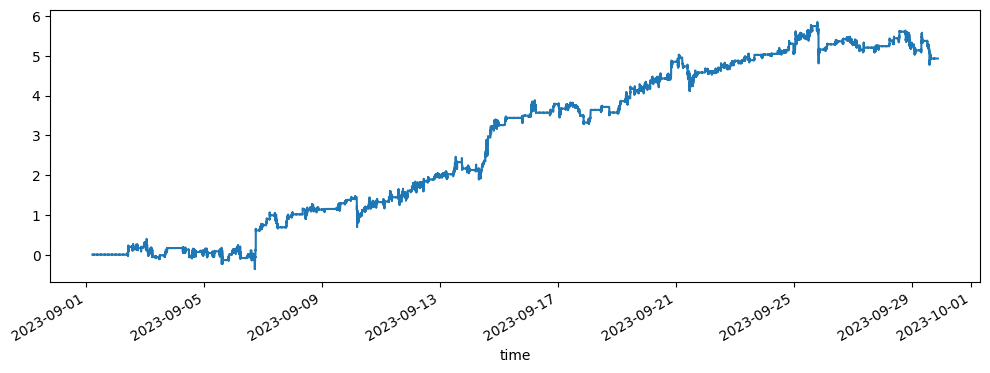

symbols: ['KSMUSDT', 'KP3RUSDT']


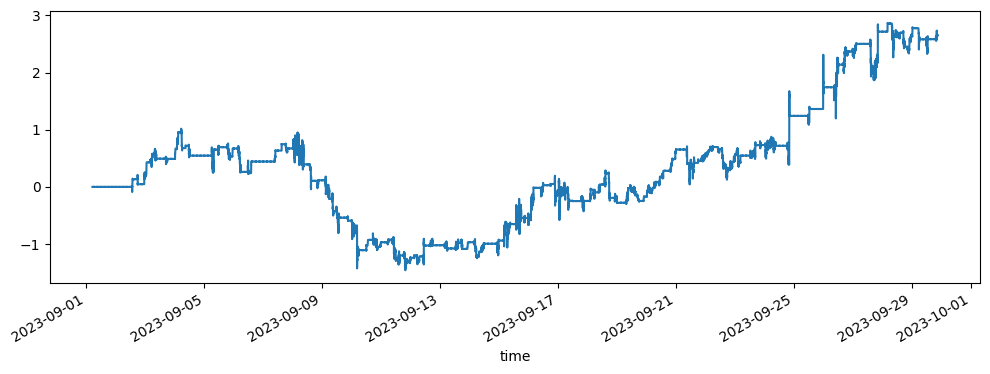

symbols: ['COMPUSDT', 'LTCUSDT']


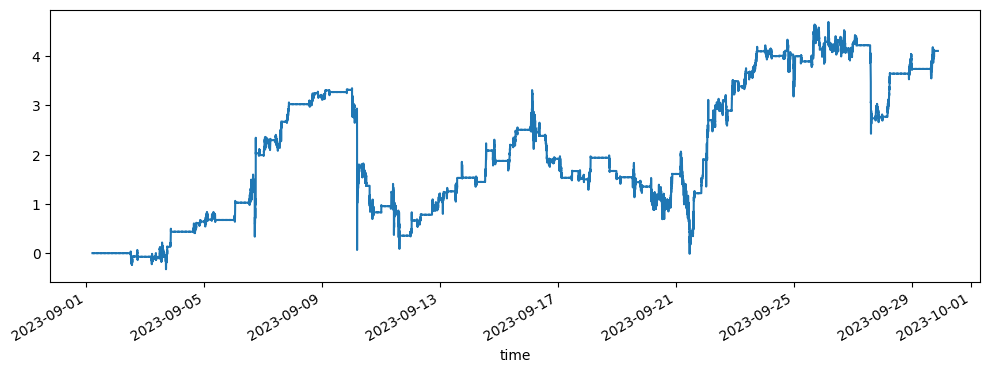

symbols: ['ALCXUSDT', 'BIFIUSDT']


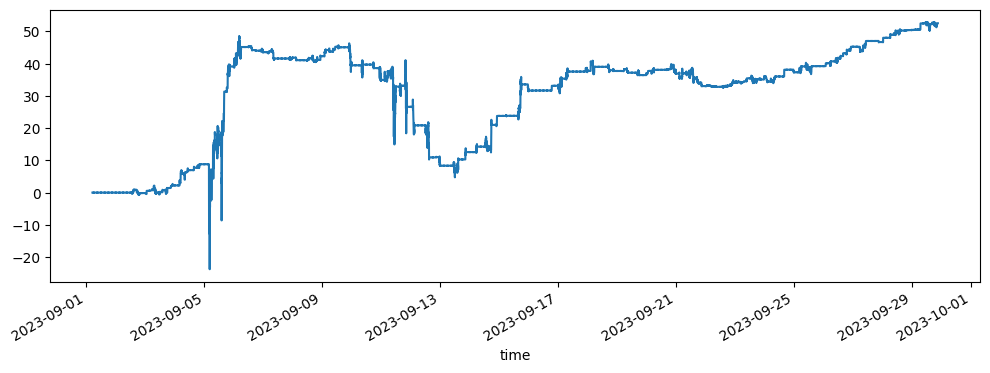

symbols: ['AAVEUSDT', 'BNBUSDT']


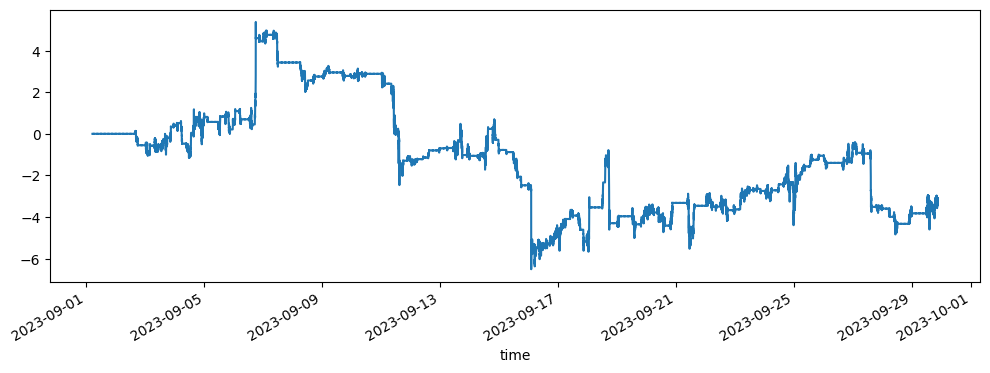

symbols: ['FARMUSDT', 'GMXUSDT']


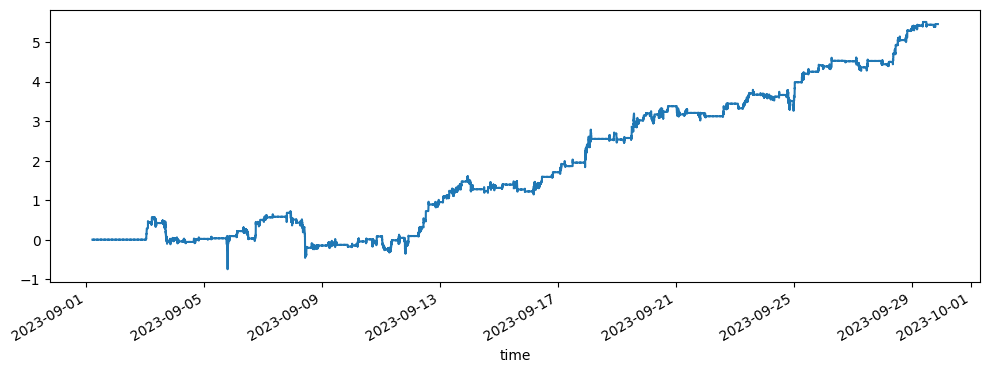

In [753]:
trading_param = algo.statarbitrage.bband.TradingParam(60, 2.0)
for symbols in symbols_sets:
    print(f'symbols: {symbols}')
    values_list = get_trading_result(symbols, trading_param, if_evecs=True)
    values_concat = pd.concat(values_list)
    ax = values_concat.profit_raw.cumsum().plot(figsize=(12, 4))
    ymin, ymax = 0, values_concat.profit_raw.cumsum().max()
    
    #ax.vlines(x=list(df_rolling_wgt_resampled.index), ymin=ymin, ymax=ymax, color='g', linestyles='dashed', label='rebalance')
    #ax.vlines(x=list(values_concat[values_concat.position_changed == +1].index), ymin=ymin, ymax=ymax, color='b', linestyles='dashed', label='enter')
    #ax.vlines(x=list(values_concat[values_concat.position_changed == -1].index), ymin=ymin, ymax=ymax, color='r', linestyles='solid', label='leave')
    
    plt.show()

In [743]:
fitting_window, rebalance_period = 180, 180
symbols = ['WNXMUSDT', 'GNOUSDT', 'ZECUSDT']
sample_period_minutes = 1
#df_prices = get_close_between_date(sample_period_minutes, symbols, date_str_20220919, date_str_20220922)
df_prices = get_close_between_date(sample_period_minutes, symbols, date_str_20230901, date_str_20230930).dropna()
df_rolling_evecs, df_rolling_evecs_resampled = get_var1_wgts_values_transpose_rolling(
    df_prices, window=fitting_window, rebalance_period=rebalance_period, sample_unit_minutes=1, order=0, if_evecs=True)
df_rolling_wgt, df_rolling_wgt_resampled = get_var1_wgts_values_transpose_rolling(
    df_prices, window=fitting_window, rebalance_period=rebalance_period, sample_unit_minutes=1, order=0, if_evecs=False)

In [718]:
df_rolling_evecs

symbol,BNBUPUSDT,BNBUSDT,SOLUSDT
time,,,
2023-08-06 02:56:00,NaN,NaN,NaN
2023-08-06 03:12:00,NaN,NaN,NaN
2023-08-06 03:13:00,NaN,NaN,NaN
2023-08-06 03:14:00,NaN,NaN,NaN
2023-08-06 03:15:00,NaN,NaN,NaN
...,...,...,...
2023-08-30 23:55:00,-0.607855,0.543199,-0.579178
2023-08-30 23:56:00,-0.617441,0.540398,-0.571609
2023-08-30 23:57:00,-0.616928,0.545700,-0.567108


In [665]:
df_prices_list = []
bband_window = 60
df_wgt = df_rolling_wgt_resampled
for i, index_head in enumerate(df_wgt.index):
    if i == len(df_wgt.index)-1: continue

    index_head_buffered = index_head - pd.Timedelta(minutes=bband_window * sample_period_minutes)
    index_tail = df_wgt.index[i+1]
    df_prices_i = df_prices[(df_prices.index < index_tail) & (df_prices.index >= index_head_buffered)]
    df_prices_list.append((index_head_buffered, index_head, index_tail, df_prices_i, df_wgt.loc[index_head]))

In [666]:
trading_param = algo.statarbitrage.bband.TradingParam(bband_window, 2.0)
values_list = []
for index_head_buffered, index_head, index_tail, df_prices_i, wgt in df_prices_list:
    values_i = algo.statarbitrage.bband.add_features(df_prices_i, wgt, trading_param)
    values_i['value_0'] = values_i.value - values_i.value.iloc[0]
    values_list.append(values_i)

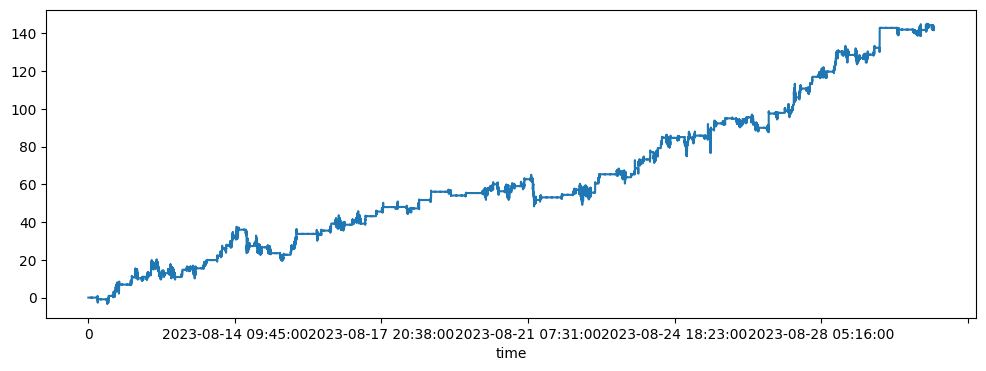

In [667]:
values_concat = pd.concat(values_list)
ax = values_concat.profit_raw.cumsum().plot(figsize=(12, 4))
ymin, ymax = 0, values_concat.profit_raw.cumsum().max()

plt.show()

<Axes: xlabel='time'>

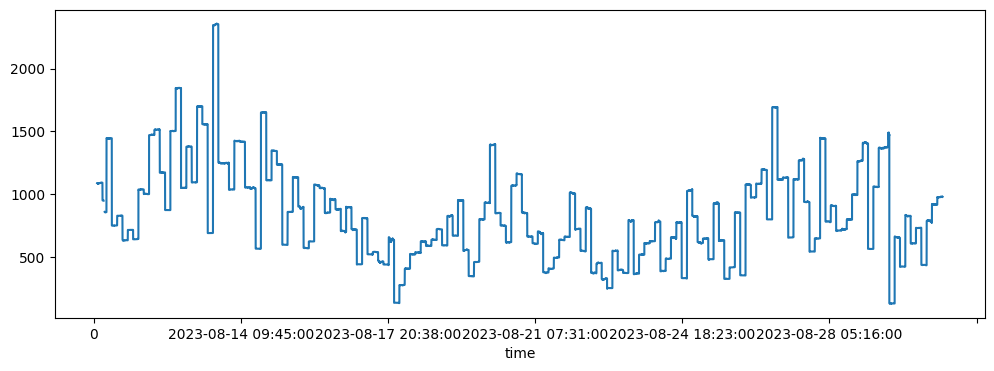

In [668]:
values_concat.mean_size.plot(figsize=(12, 4))

<Axes: xlabel='time'>

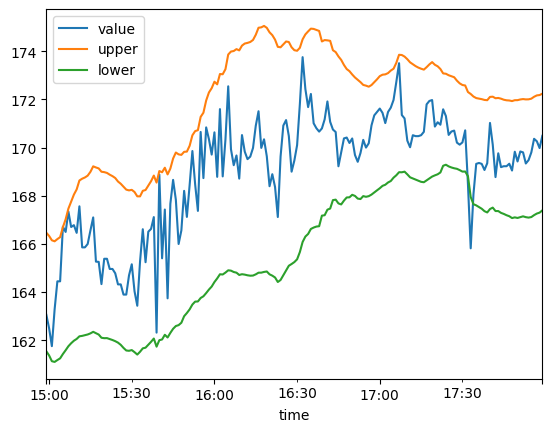

In [302]:
values_list[93][['value', 'upper', 'lower']].plot()

<Axes: xlabel='time'>

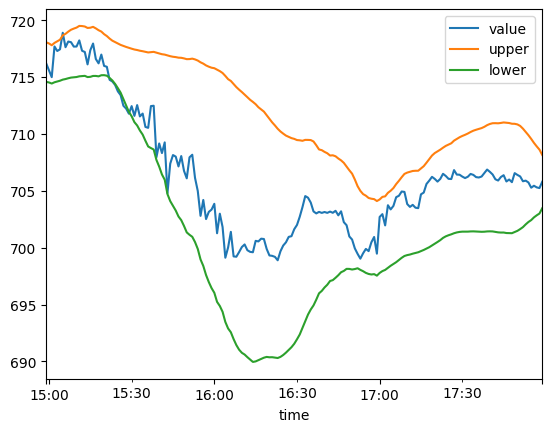

In [679]:
values_list[93][['value', 'upper', 'lower']].plot()

<Axes: xlabel='time'>

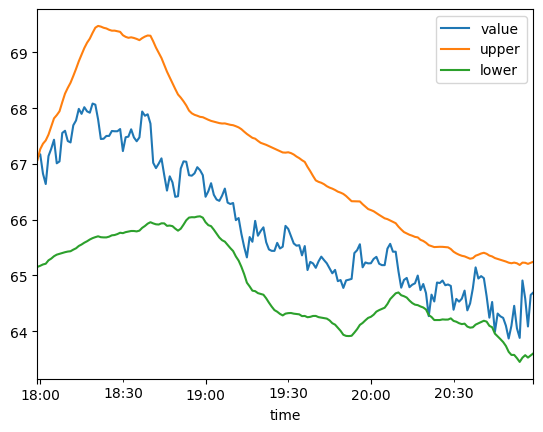

In [680]:
values_list[94][['value', 'upper', 'lower']].plot()

<Axes: xlabel='time'>

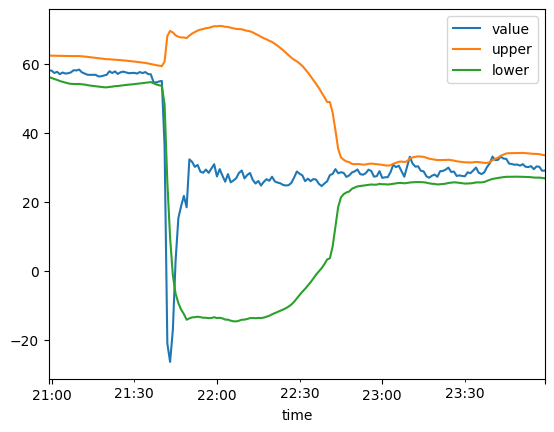

In [681]:
values_list[95][['value', 'upper', 'lower']].plot()

<Axes: xlabel='time'>

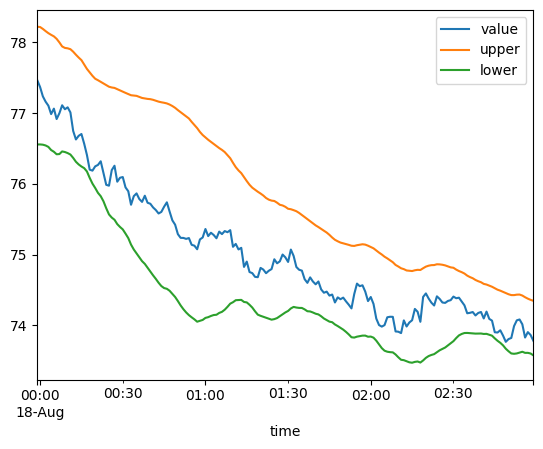

In [682]:
values_list[96][['value', 'upper', 'lower']].plot()

<Axes: xlabel='time'>

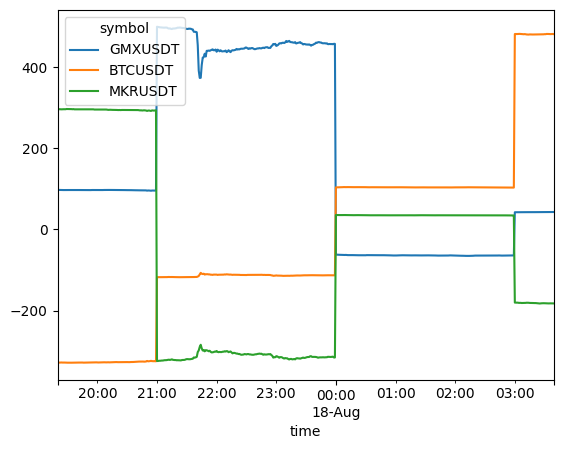

In [683]:
(df_prices * df_rolling_wgt_resampled.resample('1min').first().ffill()).iloc[17000:17500].plot()

<Axes: xlabel='time'>

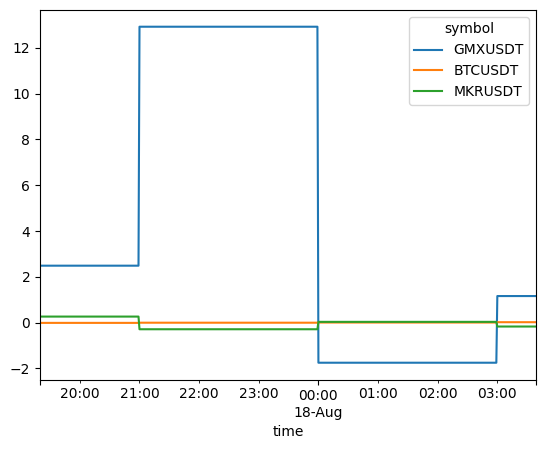

In [684]:
df_rolling_wgt_resampled.resample('1min').first().ffill().iloc[17000:17500].plot()

<Axes: xlabel='time'>

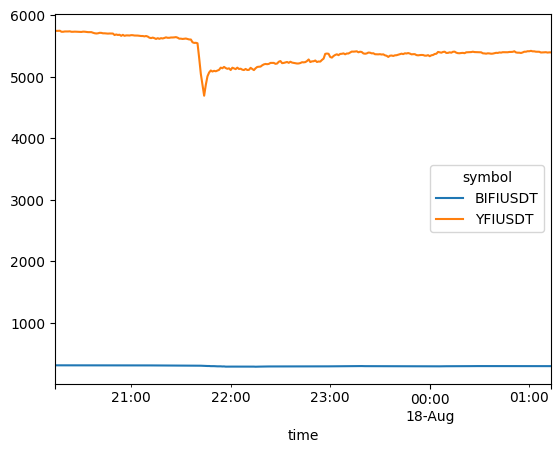

In [660]:
df_prices.iloc[10000:10300].plot()

<Axes: xlabel='time'>

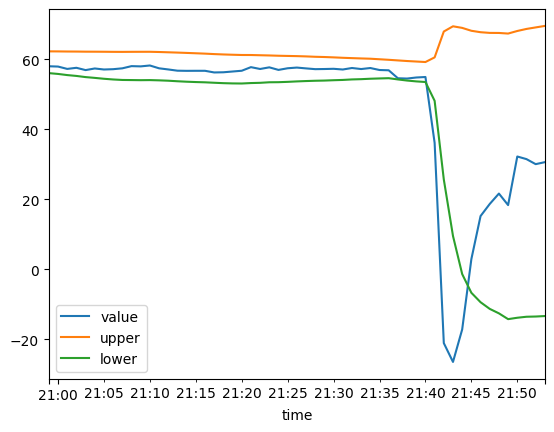

In [607]:
values_list[95].iloc[0:55][['value', 'upper', 'lower']].plot()

In [350]:
values_list[95].iloc[0:10]

,value,rebalanced,rebalance_age,upper,lower,value_prev,lower_crossed_upward,lower_crossed_downward,upper_crossed_upward,upper_crossed_downward,in_position,position_changed,mean_size,position_size,profit_raw,profit,value_0
time,,,,,,,,,,,,,,,,,
2023-08-17 20:59:00,197.678883,0,60,199.556750,196.115248,198.096973,0,0,0,0,0,NaN,11484.300135,0.000000,NaN,NaN,0.000000
2023-08-17 21:00:00,196.827749,0,61,199.455753,196.014269,197.678883,0,0,0,0,0,0.0,11495.700049,0.000000,-0.000000,-0.000000,-0.851134
2023-08-17 21:01:00,195.689635,0,62,199.316355,195.743995,196.827749,0,1,0,0,0,0.0,11498.022285,0.000000,-0.000000,-0.000000,-1.989248
2023-08-17 21:02:00,196.686304,0,63,199.240919,195.650436,195.689635,1,0,0,0,1,1.0,11498.424305,0.000000,0.000000,0.000000,-0.992578
2023-08-17 21:03:00,194.137323,0,64,199.068686,195.160217,196.686304,0,1,0,0,1,0.0,11486.195017,11486.195017,-2.548981,-0.012960,-3.541560
2023-08-17 21:04:00,195.008098,0,65,198.947165,194.860020,194.137323,1,0,0,0,1,0.0,11482.347647,11486.195017,0.870775,0.004485,-2.670785
2023-08-17 21:05:00,195.085826,0,66,198.806383,194.636901,195.008098,0,0,0,0,1,0.0,11488.625791,11486.195017,0.077729,0.000399,-2.593057
2023-08-17 21:06:00,195.145393,0,67,198.694808,194.432955,195.085826,0,0,0,0,1,0.0,11480.122225,11486.195017,0.059566,0.000305,-2.533490
2023-08-17 21:07:00,194.896758,0,68,198.566908,194.227172,195.145393,0,0,0,0,1,0.0,11474.693686,11486.195017,-0.248634,-0.001274,-2.782124


In [344]:
values_list[95].iloc[39:48]

,value,rebalanced,rebalance_age,upper,lower,value_prev,lower_crossed_upward,lower_crossed_downward,upper_crossed_upward,upper_crossed_downward,in_position,position_changed,mean_size,position_size,profit_raw,profit,value_0
time,,,,,,,,,,,,,,,,,
2023-08-17 21:38:00,185.318683,0,99,196.761479,181.625366,185.412153,0,0,0,0,1,0.0,11437.465204,11486.195017,-0.093470,-0.000504,-12.360199
2023-08-17 21:39:00,187.181548,0,100,196.664258,181.320201,185.318683,0,0,0,0,1,0.0,11440.021289,11486.195017,1.862865,0.010052,-10.497335
2023-08-17 21:40:00,187.683243,0,101,196.641494,181.081162,187.181548,0,0,0,0,1,0.0,11438.519034,11486.195017,0.501695,0.002680,-9.995640
2023-08-17 21:41:00,185.229852,0,102,196.515411,180.480934,187.683243,0,0,0,0,1,0.0,11345.714662,11486.195017,-2.453391,-0.013072,-12.449031
2023-08-17 21:42:00,144.899558,0,103,198.955994,169.320459,185.229852,0,1,0,0,1,0.0,11190.363888,11486.195017,-40.330293,-0.217731,-52.779324
2023-08-17 21:43:00,225.484735,0,104,205.280144,171.265755,144.899558,1,0,1,0,1,0.0,10819.834398,11486.195017,80.585177,0.556145,27.805852
2023-08-17 21:44:00,301.159549,0,105,232.227344,166.896229,225.484735,0,0,0,0,1,0.0,10480.866355,11486.195017,75.674814,0.335609,103.480666
2023-08-17 21:45:00,268.614421,0,106,244.281056,168.653239,301.159549,0,0,0,0,1,0.0,10683.840744,11486.195017,-32.545128,-0.108066,70.935539
2023-08-17 21:46:00,242.516953,0,107,249.743334,170.401014,268.614421,0,0,0,1,0,-1.0,10758.113655,11486.195017,-26.097468,-0.097156,44.838070


In [340]:
df_prices.iloc[10085:10100]

symbol,BTCUSDT,BTCBUSD,BNBBUSD
time,,,
2023-08-17 21:38:00,27573.68,27533.57,221.8
2023-08-17 21:39:00,27578.74,27541.68,221.9
2023-08-17 21:40:00,27574.80,27540.52,221.6
2023-08-17 21:41:00,27351.64,27311.28,220.5
2023-08-17 21:42:00,27000.00,26874.42,219.8
2023-08-17 21:43:00,26054.32,26063.61,216.8
2023-08-17 21:44:00,25188.01,25296.86,218.2
2023-08-17 21:45:00,25699.03,25777.76,216.5
2023-08-17 21:46:00,25894.61,25930.44,216.7


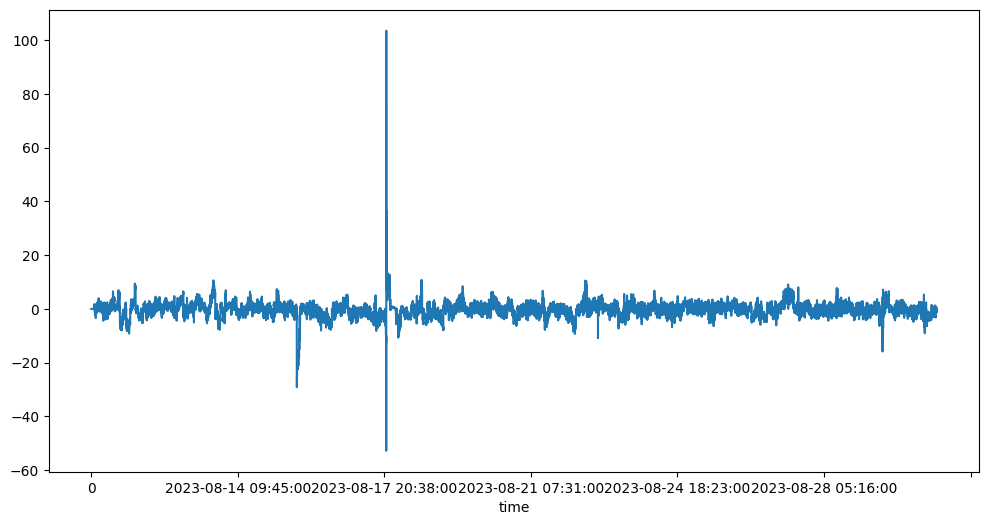

In [413]:
values_concat = pd.concat(values_list)
ax = values_concat.value_0.plot(figsize=(12, 6))
ymin, ymax = values_concat.value_0.min(), values_concat.value_0.max()

#ax.vlines(x=list(df_rolling_wgt_resampled.index), ymin=ymin, ymax=ymax, color='g', linestyles='dashed', label='rebalance')

plt.show()

<Axes: xlabel='time'>

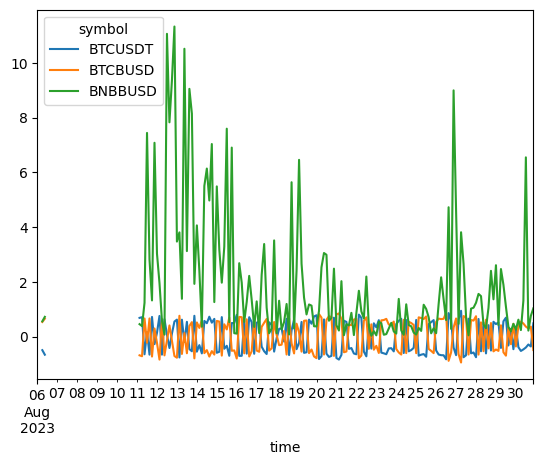

In [266]:
df_rolling_wgt_resampled.plot()

In [259]:
df_rolling_wgt_resampled.index

DatetimeIndex(['2023-08-06 00:00:00', '2023-08-06 03:00:00',
               '2023-08-06 06:00:00', '2023-08-06 09:00:00',
               '2023-08-06 12:00:00', '2023-08-06 15:00:00',
               '2023-08-06 18:00:00', '2023-08-06 21:00:00',
               '2023-08-07 00:00:00', '2023-08-07 03:00:00',
               ...
               '2023-08-29 18:00:00', '2023-08-29 21:00:00',
               '2023-08-30 00:00:00', '2023-08-30 03:00:00',
               '2023-08-30 06:00:00', '2023-08-30 09:00:00',
               '2023-08-30 12:00:00', '2023-08-30 15:00:00',
               '2023-08-30 18:00:00', '2023-08-30 21:00:00'],
              dtype='datetime64[ns]', name='time', length=200, freq='180T')

In [257]:
df_rolling_wgt_resampled

symbol,BTCUSDT,BTCBUSD,BNBBUSD
time,,,
2023-08-06 00:00:00,NaN,NaN,NaN
2023-08-06 03:00:00,NaN,NaN,NaN
2023-08-06 06:00:00,-0.498671,0.531318,0.555894
2023-08-06 09:00:00,-0.664215,0.653163,0.718548
2023-08-06 12:00:00,NaN,NaN,NaN
...,...,...,...
2023-08-30 09:00:00,-0.470847,0.475181,1.309584
2023-08-30 12:00:00,-0.401504,0.361844,6.547826
2023-08-30 15:00:00,-0.291655,0.295036,0.216342


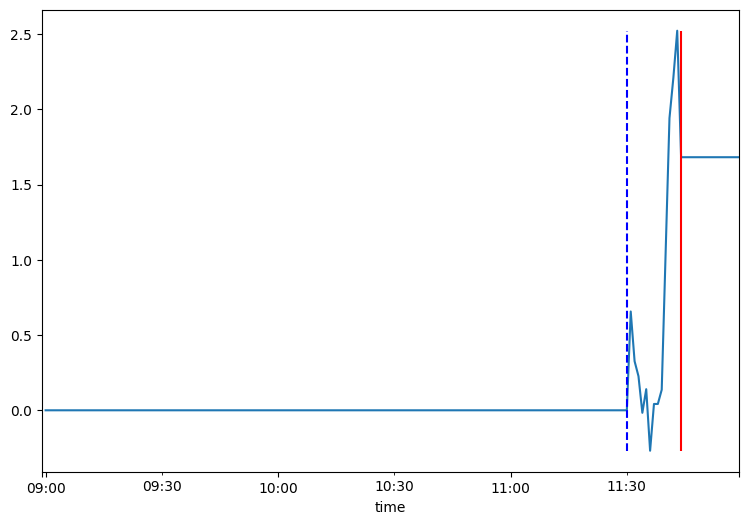

In [414]:
i = len(values_list) // 2
values_i = values_list[i]
ax = values_i.profit_raw.cumsum().plot(figsize=(9, 6))
ymin, ymax = values_i.profit_raw.cumsum().min(), values_i.profit_raw.cumsum().max()

ax.vlines(x=list(values_i[values_i.position_changed == +1].index), ymin=ymin, ymax=ymax, color='b', linestyles='dashed', label='enter')
ax.vlines(x=list(values_i[values_i.position_changed == -1].index), ymin=ymin, ymax=ymax, color='r', linestyles='solid', label='leave')

plt.show()

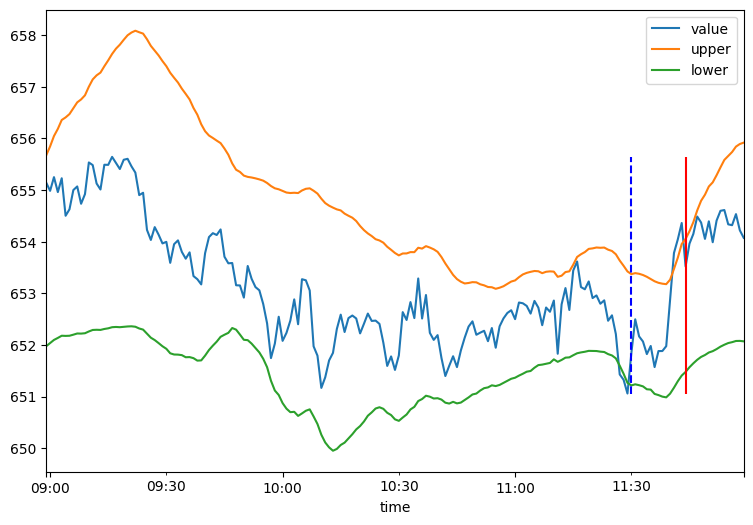

In [415]:
# plot dataframe; the index is a datetime index
#ax = values_rolling[['value', 'upper', 'lower']].plot(figsize=(9, 6))
ax = values_i[['value', 'upper', 'lower']].plot(figsize=(9, 6))
ymin, ymax = values_i.value.min(), values_i.value.max()

ax.vlines(x=list(values_i[values_i.position_changed == +1].index), ymin=ymin, ymax=ymax, color='b', linestyles='dashed', label='enter')
ax.vlines(x=list(values_i[values_i.position_changed == -1].index), ymin=ymin, ymax=ymax, color='r', linestyles='solid', label='leave')

plt.show()

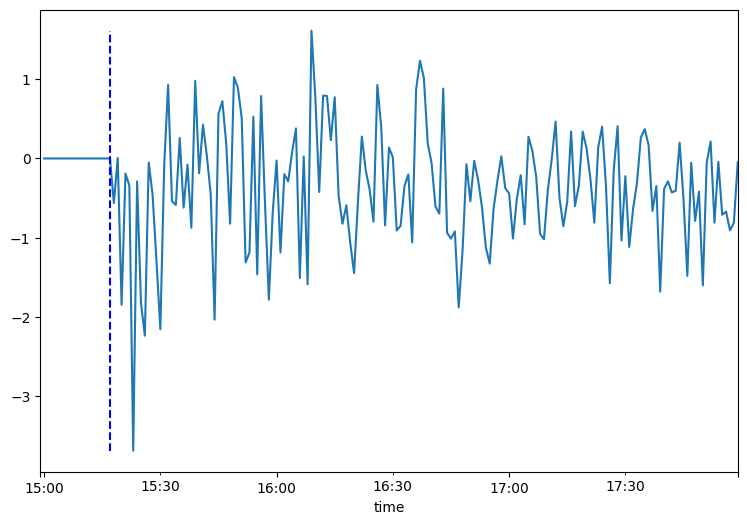

In [253]:
i = -2
values_i = values_list[i]
ax = values_i.profit_raw.cumsum().plot(figsize=(9, 6))
ymin, ymax = values_i.profit_raw.cumsum().min(), values_i.profit_raw.cumsum().max()

ax.vlines(x=list(values_i[values_i.position_changed == +1].index), ymin=ymin, ymax=ymax, color='b', linestyles='dashed', label='enter')
ax.vlines(x=list(values_i[values_i.position_changed == -1].index), ymin=ymin, ymax=ymax, color='r', linestyles='solid', label='leave')

plt.show()

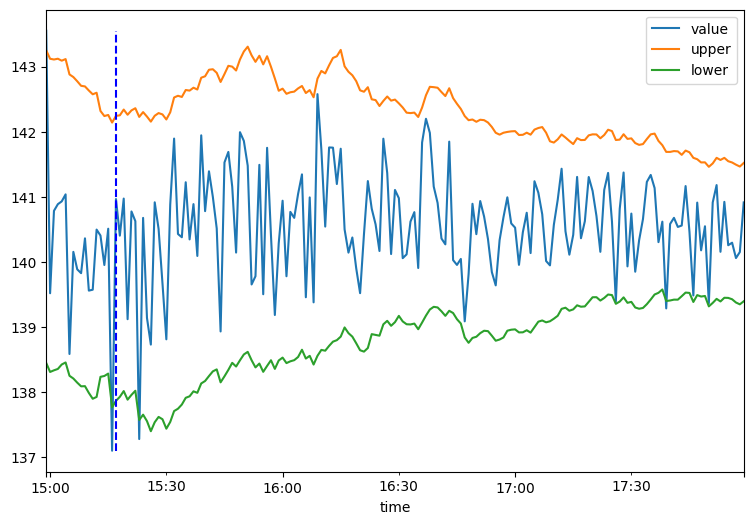

In [254]:
# plot dataframe; the index is a datetime index
#ax = values_rolling[['value', 'upper', 'lower']].plot(figsize=(9, 6))
ax = values_i[['value', 'upper', 'lower']].plot(figsize=(9, 6))
ymin, ymax = values_i.value.min(), values_i.value.max()

ax.vlines(x=list(values_i[values_i.position_changed == +1].index), ymin=ymin, ymax=ymax, color='b', linestyles='dashed', label='enter')
ax.vlines(x=list(values_i[values_i.position_changed == -1].index), ymin=ymin, ymax=ymax, color='r', linestyles='solid', label='leave')

plt.show()

<Axes: xlabel='time'>

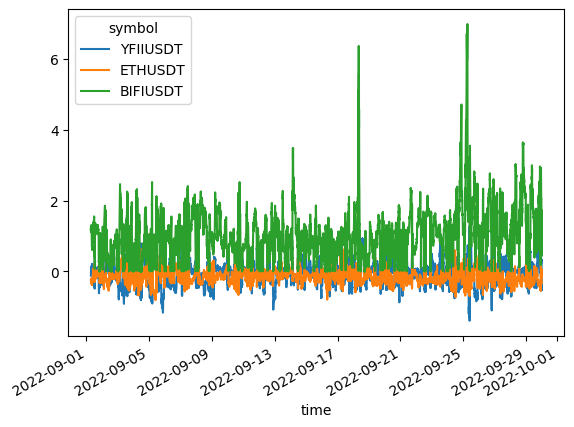

In [75]:
df_rolling_wgt.plot()

<Axes: xlabel='time'>

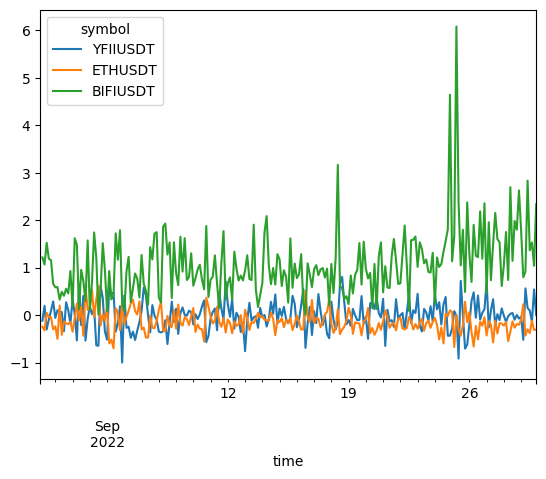

In [76]:
df_rolling_wgt_resampled.plot()